# 03 - Modelo Alternativo 1: Random Forest

## Descripción

Este notebook presenta una **aproximación alternativa** al problema usando **Random Forest Classifier**.

### ¿Por qué Random Forest?

- **Interpretabilidad**: Fácil de entender la importancia de features
- **Robusto**: Menos propenso a overfitting que un árbol individual
- **Sin necesidad de escalado**: No requiere estandarización de variables
- **Maneja bien datos categóricos**: Trabaja nativamente con one-hot encoding


---
## 1. Importaciones y Configuración


In [1]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Preprocesamiento
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Modelo Random Forest
from sklearn.ensemble import RandomForestClassifier

# Métricas
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Configuración
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Semilla para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Librerías cargadas correctamente")


✓ Librerías cargadas correctamente


---
## 2. Carga de Datos


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test_ids = test['ID'].copy()

print(f"Train: {train.shape}")
print(f"Test: {test.shape}")


Train: (692500, 21)
Test: (296786, 20)


---
## 3. Preprocesamiento

Aplicamos el mismo pipeline pero **sin estandarización** ya que Random Forest no la necesita.


In [4]:
def preprocess_data(df, is_train=True):
    """Preprocesamiento sin estandarización para Random Forest"""
    df_proc = df.copy()
    
    # Eliminar duplicados
    if 'F_TIENEINTERNET.1' in df_proc.columns:
        df_proc = df_proc.drop('F_TIENEINTERNET.1', axis=1)
    
    # E_VALORMATRICULAUNIVERSIDAD
    def convertir_valor_matricula(valor):
        if pd.isna(valor): return np.nan
        elif 'Menos de 500 mil' in valor: return 250000
        elif 'Entre 500 mil y menos de 1 millón' in valor: return 750000
        elif 'Entre 1 millón y menos de 2.5 millones' in valor: return 1750000
        elif 'Entre 2.5 millones y menos de 4 millones' in valor: return 3250000
        elif 'Entre 4 millones y menos de 5.5 millones' in valor: return 4750000
        elif 'Entre 5.5 millones y menos de 7 millones' in valor: return 6250000
        elif 'Más de 7 millones' in valor: return 7500000
        elif 'No pagó matrícula' in valor: return 0
        else: return np.nan
    
    if 'E_VALORMATRICULAUNIVERSIDAD' in df_proc.columns:
        df_proc['E_VALORMATRICULAUNIVERSIDAD'] = df_proc['E_VALORMATRICULAUNIVERSIDAD'].apply(convertir_valor_matricula)
        df_proc['E_VALORMATRICULAUNIVERSIDAD'].fillna(df_proc['E_VALORMATRICULAUNIVERSIDAD'].mean(), inplace=True)
    
    # E_HORASSEMANATRABAJA
    def convertir_horas_trabajadas(valor):
        if pd.isna(valor): return np.nan
        valor = str(valor)
        if valor == '0': return 0
        elif 'Menos de 10 horas' in valor: return 5
        elif 'Entre 11 y 20 horas' in valor: return 15.5
        elif 'Entre 21 y 30 horas' in valor: return 25.5
        elif 'Más de 30 horas' in valor: return 35
        return np.nan
    
    if 'E_HORASSEMANATRABAJA' in df_proc.columns:
        df_proc['E_HORASSEMANATRABAJA'] = df_proc['E_HORASSEMANATRABAJA'].apply(convertir_horas_trabajadas)
        df_proc['E_HORASSEMANATRABAJA'].fillna(0, inplace=True)
    
    # F_ESTRATOVIVIENDA
    if 'F_ESTRATOVIVIENDA' in df_proc.columns:
        estrato_map = {'Sin Estrato': 0, 'Estrato 1': 1, 'Estrato 2': 2, 
                       'Estrato 3': 3, 'Estrato 4': 4, 'Estrato 5': 5, 'Estrato 6': 6}
        df_proc['F_ESTRATOVIVIENDA'] = df_proc['F_ESTRATOVIVIENDA'].map(estrato_map)
        df_proc['F_ESTRATOVIVIENDA'].fillna(0, inplace=True)
    
    # Variables binarias
    binary_cols = ['F_TIENEINTERNET', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 
                   'F_TIENECOMPUTADOR', 'E_PRIVADO_LIBERTAD', 'E_PAGOMATRICULAPROPIO']
    for col in binary_cols:
        if col in df_proc.columns:
            df_proc[col] = df_proc[col].map({'Si': 1, 'No': 0})
            df_proc[col].fillna(0, inplace=True)
    
    # Target
    if is_train and 'RENDIMIENTO_GLOBAL' in df_proc.columns:
        target_map = {'bajo': 0, 'medio-bajo': 1, 'medio-alto': 2, 'alto': 3}
        df_proc['RENDIMIENTO_GLOBAL'] = df_proc['RENDIMIENTO_GLOBAL'].map(target_map)
    
    # Educación padres - One-hot
    def to_onehot(x):
        values = np.unique(x)
        indices = [np.argwhere(i == values)[0][0] for i in x]
        return np.eye(len(values))[indices].astype(int)
    
    def replace_column_with_onehot(data, col):
        values = np.unique(data[col])
        onehot_matrix = to_onehot(data[col].values)
        return pd.DataFrame(onehot_matrix, 
                          columns=[f"{col}_{values[i]}" for i in range(onehot_matrix.shape[1])], 
                          index=data.index)
    
    for col in ['F_EDUCACIONMADRE', 'F_EDUCACIONPADRE']:
        if col in df_proc.columns:
            df_proc[col].fillna('No Aplica', inplace=True)
            onehot_df = replace_column_with_onehot(df_proc[[col]], col)
            df_proc = df_proc.join(onehot_df)
            df_proc.drop(col, axis=1, inplace=True)
    
    # E_PRGM_ACADEMICO
    if 'E_PRGM_ACADEMICO' in df_proc.columns:
        le = LabelEncoder()
        df_proc['E_PRGM_ACADEMICO'] = le.fit_transform(df_proc['E_PRGM_ACADEMICO'])
    
    # E_PRGM_DEPARTAMENTO
    if 'E_PRGM_DEPARTAMENTO' in df_proc.columns:
        df_proc['E_PRGM_DEPARTAMENTO'].fillna('DESCONOCIDO', inplace=True)
        depto_onehot = replace_column_with_onehot(df_proc[['E_PRGM_DEPARTAMENTO']], 'E_PRGM_DEPARTAMENTO')
        df_proc = df_proc.join(depto_onehot)
        df_proc.drop('E_PRGM_DEPARTAMENTO', axis=1, inplace=True)
    
    # Indicadores
    indicator_cols = [col for col in df_proc.columns if col.startswith('INDICADOR_')]
    for col in indicator_cols:
        if df_proc[col].isnull().sum() > 0:
            df_proc[col].fillna(df_proc[col].median(), inplace=True)
    
    # Feature Engineering
    recursos = ['F_TIENEINTERNET', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'F_TIENECOMPUTADOR']
    recursos = [c for c in recursos if c in df_proc.columns]
    if recursos:
        df_proc['TOTAL_RECURSOS_HOGAR'] = df_proc[recursos].sum(axis=1)
    
    if indicator_cols:
        df_proc['PROMEDIO_INDICADORES'] = df_proc[indicator_cols].mean(axis=1)
    
    # Eliminar ID y PERIODO
    for col in ['ID', 'PERIODO_ACADEMICO']:
        if col in df_proc.columns:
            df_proc = df_proc.drop(col, axis=1)
    
    return df_proc

print("Preprocesando train...")
train_processed = preprocess_data(train, is_train=True)
print("\nPreprocesando test...")
test_processed = preprocess_data(test, is_train=False)
print(f"\n✓ Train: {train_processed.shape}")
print(f"✓ Test: {test_processed.shape}")


Preprocesando train...

Preprocesando test...

✓ Train: (692500, 72)
✓ Test: (296786, 71)


In [5]:
# Separar features y target
y = train_processed['RENDIMIENTO_GLOBAL'].copy()
X = train_processed.drop('RENDIMIENTO_GLOBAL', axis=1)
X_test = test_processed.copy()

# Alinear columnas
all_cols = sorted(list(set(X.columns) | set(X_test.columns)))
X = X.reindex(columns=all_cols, fill_value=0)
X_test = X_test.reindex(columns=all_cols, fill_value=0)

print(f"✓ X: {X.shape}")
print(f"✓ X_test: {X_test.shape}")


✓ X: (692500, 71)
✓ X_test: (296786, 71)


---
## 4. División de Datos


In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Train: {X_train.shape[0]:,}")
print(f"Validation: {X_val.shape[0]:,}")
print(f"Features: {X_train.shape[1]}")


Train: 554,000
Validation: 138,500
Features: 71


---
## 5. Modelo Base Random Forest


In [7]:
print("="*80)
print("RANDOM FOREST - MODELO BASE")
print("="*80)

rf_base = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

rf_base.fit(X_train, y_train)

y_train_pred_base = rf_base.predict(X_train)
y_val_pred_base = rf_base.predict(X_val)

train_acc_base = accuracy_score(y_train, y_train_pred_base)
val_acc_base = accuracy_score(y_val, y_val_pred_base)

print(f"\nAccuracy Train: {train_acc_base:.4f}")
print(f"Accuracy Validation: {val_acc_base:.4f}")
print(f"Diferencia: {train_acc_base - val_acc_base:.4f}")


RANDOM FOREST - MODELO BASE

Accuracy Train: 1.0000
Accuracy Validation: 0.3940
Diferencia: 0.6060


---
## 6. Optimización de Hiperparámetros

Usamos RandomizedSearchCV para explorar el espacio de hiperparámetros eficientemente.


In [8]:
print("="*80)
print("OPTIMIZACIÓN DE HIPERPARÁMETROS")
print("="*80)

param_dist = {
    'n_estimators': [200, 300, 400],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,  # Número de combinaciones a probar
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

print("\nBuscando mejores hiperparámetros...")
random_search.fit(X_train, y_train)

print("\n✓ Optimización completa")
print(f"\nMejores hiperparámetros:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nMejor score CV: {random_search.best_score_:.4f}")


OPTIMIZACIÓN DE HIPERPARÁMETROS

Buscando mejores hiperparámetros...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✓ Optimización completa

Mejores hiperparámetros:
  n_estimators: 200
  min_samples_split: 10
  min_samples_leaf: 2
  max_features: None
  max_depth: 30
  bootstrap: True

Mejor score CV: 0.4094


---
## 7. Modelo Final Optimizado


In [9]:
best_rf = random_search.best_estimator_

y_train_pred = best_rf.predict(X_train)
y_val_pred = best_rf.predict(X_val)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

print("="*80)
print("RANDOM FOREST OPTIMIZADO")
print("="*80)
print(f"\nAccuracy Train: {train_acc:.4f}")
print(f"Accuracy Validation: {val_acc:.4f}")
print(f"Diferencia: {train_acc - val_acc:.4f}")

print(f"\nMejora vs modelo base:")
print(f"  Train: {train_acc - train_acc_base:+.4f}")
print(f"  Validation: {val_acc - val_acc_base:+.4f}")


RANDOM FOREST OPTIMIZADO

Accuracy Train: 0.9356
Accuracy Validation: 0.4090
Diferencia: 0.5267

Mejora vs modelo base:
  Train: -0.0644
  Validation: +0.0149


---
## 8. Evaluación


In [10]:
target_names = ['bajo', 'medio-bajo', 'medio-alto', 'alto']
print(classification_report(y_val, y_val_pred, target_names=target_names))


              precision    recall  f1-score   support

        bajo       0.44      0.50      0.47     34597
  medio-bajo       0.31      0.28      0.29     34455
  medio-alto       0.31      0.27      0.29     34324
        alto       0.54      0.58      0.56     35124

    accuracy                           0.41    138500
   macro avg       0.40      0.41      0.40    138500
weighted avg       0.40      0.41      0.40    138500



In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matriz de Confusión - Random Forest', fontsize=14, fontweight='bold')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()


### Importancia de Features

Una de las ventajas principales de Random Forest es la interpretabilidad.


TOP 20 FEATURES MÁS IMPORTANTES:
                                              feature  importance
                                     E_PRGM_ACADEMICO    0.109100
                                          INDICADOR_1    0.105655
                                 PROMEDIO_INDICADORES    0.103104
                                          INDICADOR_2    0.100669
                                          INDICADOR_4    0.100008
                                          INDICADOR_3    0.099797
                          E_VALORMATRICULAUNIVERSIDAD    0.089815
                                 E_HORASSEMANATRABAJA    0.031038
                                 TOTAL_RECURSOS_HOGAR    0.017527
                                E_PAGOMATRICULAPROPIO    0.013042
                           E_PRGM_DEPARTAMENTO_BOGOTÁ    0.011493
  F_EDUCACIONPADRE_Secundaria (Bachillerato) completa    0.010429
  F_EDUCACIONMADRE_Secundaria (Bachillerato) completa    0.010370
                 F_EDUCACIONPADRE_Primaria 

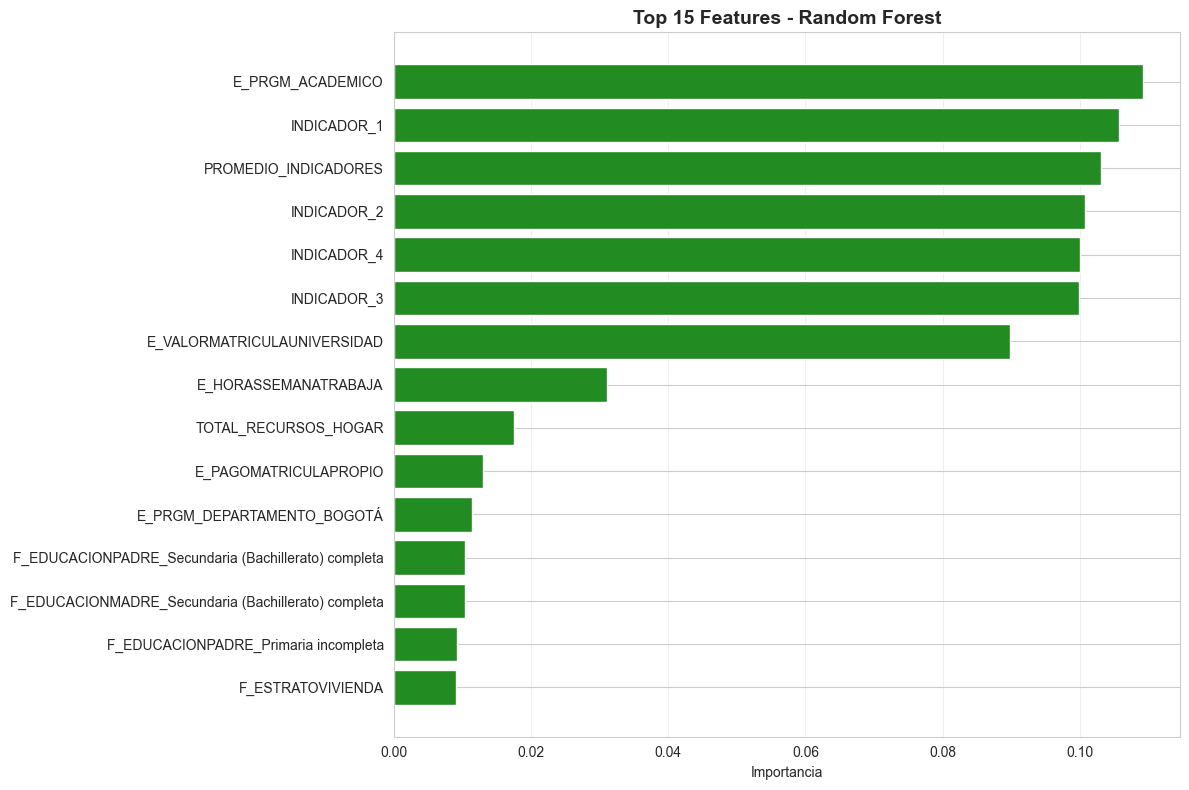

In [11]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("TOP 20 FEATURES MÁS IMPORTANTES:")
print(feature_importance.head(20).to_string(index=False))

# Visualizar
plt.figure(figsize=(12, 8))
top_15 = feature_importance.head(15)
plt.barh(range(len(top_15)), top_15['importance'].values, color='forestgreen')
plt.yticks(range(len(top_15)), top_15['feature'].values)
plt.xlabel('Importancia')
plt.title('Top 15 Features - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


---
## 9. Predicciones en Test


In [12]:
y_test_pred = best_rf.predict(X_test)

target_map_inverse = {0: 'bajo', 1: 'medio-bajo', 2: 'medio-alto', 3: 'alto'}
y_test_labels = pd.Series(y_test_pred).map(target_map_inverse)

submission_rf = pd.DataFrame({
    'ID': test_ids,
    'RENDIMIENTO_GLOBAL': y_test_labels
})

submission_rf.to_csv('submission_rf.csv', index=False)

print(f"✓ Predicciones generadas: {len(y_test_pred):,}")
print(f"\nDistribución en test:")
print(y_test_labels.value_counts().sort_index())
print(f"\n✓ Archivo guardado: submission_rf.csv")


✓ Predicciones generadas: 296,786

Distribución en test:
alto          88550
bajo          80310
medio-alto    63001
medio-bajo    64925
Name: count, dtype: int64

✓ Archivo guardado: submission_rf.csv


---
## 10. Conclusiones

### Ventajas de este enfoque:
- ✅ **No requiere escalado**: Simplifica el preprocessing
- ✅ **Interpretable**: Fácil entender qué features son importantes  
- ✅ **Robusto**: Menos sensible a outliers
- ✅ **Paralelizable**: Entrena múltiples árboles simultáneamente

